In [1]:
import numpy as np
import scipy
import scipy.stats as sps
import scipy.fftpack as spfft
import scipy.signal as spsig
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import quad
import scipy.fft as scft
import sys
import stingray as st

sys.path.insert(1, 'C:/Users/shash/UvA/Thesis/Project/MastersThesis/src/MastersThesis/scripts')

from General import *
from PowerSpec import *
from BiSpectra import *
from SimulatorFuncs import *
from CrossBispec import *
from Stats_and_Fits import get_chi_sqr

In [2]:
def get_indices_temp(freq, min, max):
    return np.argmin(np.abs(freq-min)), np.argmin(np.abs(freq-max))
def ind_const_model(f, c):
    return f / f * c
def obj_fcn2(params, data_x, data_y, model, n_stacked):
    """
    Log likelihood function to be used for fitting.
    
    """
    # m = PDS_reb.m # Number of stacked periodograms
    # data_x = xdat 
    # data_y = ydat
    model_y = model.eval(params=params, f=data_x)
    
    S = 2 * np.sum(n_stacked * (data_y/model_y + np.log(model_y) + (1/n_stacked - 1) * np.log(data_x) + 100*n_stacked))

    # return (data_y - model_y)**2/(data_y/np.sqrt(n_stacked))**2
    
    # print(S)

    return S

# Overview
 - Generate light curves
 - Modulate light curve using sinusoids
 - Calculate phase using methods

## Methods
 - What is being used right now: bin by 8*QPO freq, get phase of corr bin
 - Finer resolution, average phase over FWHM (?)
 - 

## Errors
 - Based on bootstrapping:
 - Sample bs values from all calculated ones, get errors from that
 


In [3]:
psmodel = dbl_lorentz_fwhm

# Parameters for result 1
pspar = [.007, .16, 2*.29, 0.02, 0, 2*4.3] # Strong BBN
pspar = [.01, .16, 2*.29, 0.03, 0, 2*4.3]

dt = 1/128 # Time bin size
ntimes = int(1760/dt)
print(ntimes) # Length of light curve 
expquery = 'n' # exponentiation to make the light curve flux distribution lognormal

# Cannot set rms using my newly defined dbl_lorentz_fwhm function!
rms = 0. # Set to 0 to not re-normalize

f_min = 1./(dt*ntimes) # The minimum frequency is 1/(duration of light curve)
f_max = 1/(2.*dt) # The maximum 'Nyquist' frequency is 1/(2*sampling-interval) (i.e. 1/(2*binsize)
params = tuple(pspar)

## 
# # Paramters for result 2
# pspar = [.01, .16, 2*.29, 0.03, 0, 2*4.3] # Strong BBN
# dt = 1/128 # Time bin size
# ntimes = 262144 * 8 # Length of light curve 
# expquery = 'n' # exponentiation to make the light curve flux distribution lognormal

# # Cannot set rms using my newly defined dbl_lorentz_fwhm function!
# rms = 0. # Set to 0 to not re-normalize

# f_min = 1./(dt*ntimes) # The minimum frequency is 1/(duration of light curve)
# f_max = 1/(2.*dt) # The maximum 'Nyquist' frequency is 1/(2*sampling-interval) (i.e. 1/(2*binsize)
params = tuple(pspar)

225280


Text(0.5, 1.0, 'Input Model Power Spectrum')

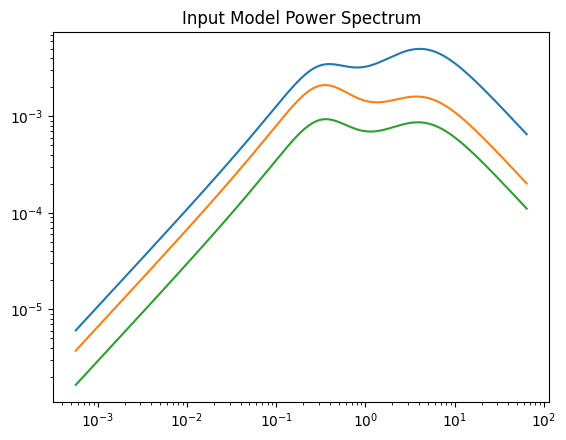

In [4]:
time = np.linspace(start=dt, stop=(dt*ntimes), num=ntimes) # Set up times for plotting
minfreq = 1./(ntimes*dt)
freq = np.linspace(start=minfreq,stop=(minfreq*ntimes//2), num=ntimes//2)

pspar = [.007, .16, 2*.29, 0.02, 0, 2*4.3] # Strong BBN
pspar = [.01, .16, 2*.29, 0.03, 0, 2*4.3]

pspars = [[.01, .16, 2*.29, 0.03, 0, 2*4.3], [.007, .16, 2*.29, 0.009, 0, 2*4.3], [.003, .16, 2*.29, 0.005, 0, 2*4.3]]
plt.figure()
for par in pspars:
    plt.plot(freq,freq*psmodel(freq,*par))

plt.yscale('log')
plt.xscale('log')
plt.title('Input Model Power Spectrum')
    # plt.show()

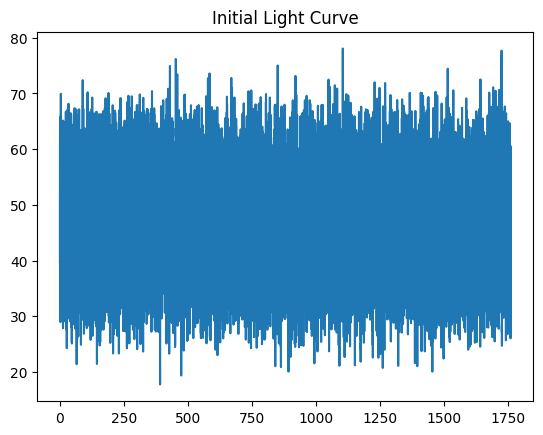

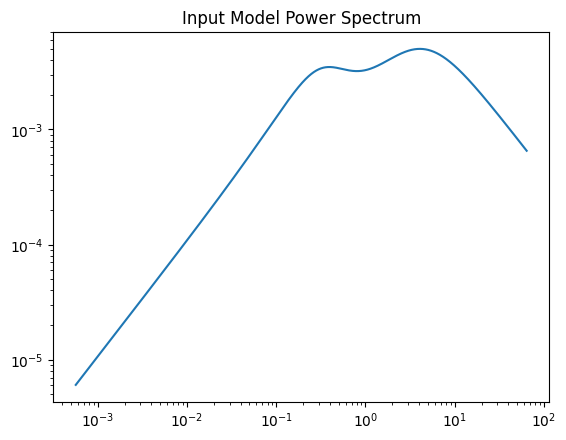

In [5]:
pspar = pspars[0]
lc = simlc(dt, ntimes, expquery, rms, psmodel, pspar)

# To convert lc to 1s
# lc = lc/lc
lc *= 6000 * dt
# lc = lc**2


time = np.linspace(start=dt, stop=(dt*ntimes), num=ntimes) # Set up times for plotting
minfreq = 1./(ntimes*dt)
freq = np.linspace(start=minfreq,stop=(minfreq*ntimes//2), num=ntimes//2)

plt.figure()
plt.plot(time, lc)
plt.title('Initial Light Curve')
plt.show()

plt.figure()
plt.plot(freq,freq*psmodel(freq,*pspar))
plt.yscale('log')
plt.xscale('log')
plt.title('Input Model Power Spectrum')
plt.show()

In [6]:
nu_f = 2.5
nu_h = 2 * nu_f

# Results 1
params_E1 = {'A1': 0.1,
             'A2': 0.05,
             'psi': 0.5*np.pi,
             'phi_0':0,
             'nu_f': nu_f,
             'nu_h': nu_h}

# Results 2
params_E1 = {'A1': 0.1,
             'A2': 0.05,
             'psi': -0.5*np.pi,
             'phi_0':0,
             'nu_f': nu_f,
             'nu_h': nu_h}

# params_E2 = {'A1': 0.06,
#              'A2': 0.03,
#              'phi_0':0,
#              'psi': 0.5*np.pi,
#              'nu_f': nu_f,
#              'nu_h': nu_h}

In [7]:
def modulate_lc_additive(lc_times, lc_counts, params, phi_stoch):
    A1 = params['A1']
    A2 = params['A2']
    psi = params['psi']
    nu1 = params['nu_f']
    nu2 = params['nu_h']
    phi0 = params['phi_0']
    
    mod_factor = 1 + A1 * np.cos(2 * np.pi * nu1 * lc_times - phi_stoch - phi0) + A2 * np.cos(2 * np.pi * nu2 * lc_times - 2 * phi_stoch - 2 * phi0 - psi)
    mod_factor *= np.mean(lc_counts)
    return mod_factor + lc_counts

(0.0, 30.0)

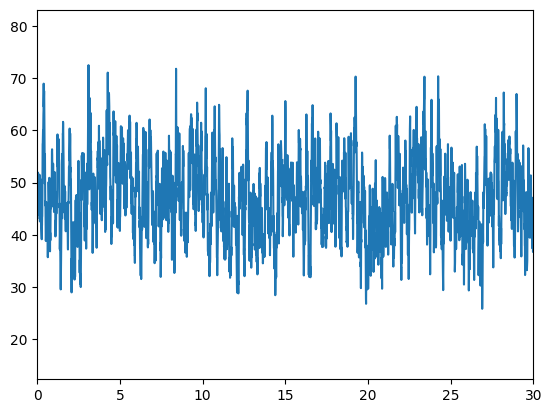

In [9]:
# Generate stochastic phase variation

# Params for result 1
# a0 = 0.02 # 0.0081 # 0.001 # 0.0001 # 0.00001 
# nu0 = 0
# hwhm = 0.2

# n_samples = len(time) 
# phi_stoch = np.cumsum(gen_stochastic_phi(a0=a0, hwhm=hwhm, nu0=nu0, dt=dt, ntimes=ntimes) - 1)

# Params for result 2
a0 = 0.015 # 0.0081 # 0.001 # 0.0001 # 0.00001 
nu0 = 0
hwhm = 0.2

n_samples = len(time) 
phi_stoch = np.cumsum(gen_stochastic_phi(a0=a0, hwhm=hwhm, nu0=nu0, dt=dt, ntimes=ntimes) - 1)

# Modulate light curve using specified params

lc_modulated = modulate_lc(lc_times=time, lc_counts=lc, params=params_E1, phi_stoch=phi_stoch)
# lc_modulated = np.random.poisson(lc_modulated)
plt.plot(time, lc_modulated)
plt.xlim(0,30)


c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\stingray\lightcurve.py:329: UserWarning: On Windows, the size of an integer is 32 bits. To avoid integer overflow, I'm converting the input array to float
  warnings.warn(


Text(0, 0.5, 'Power (frac rms norm)')

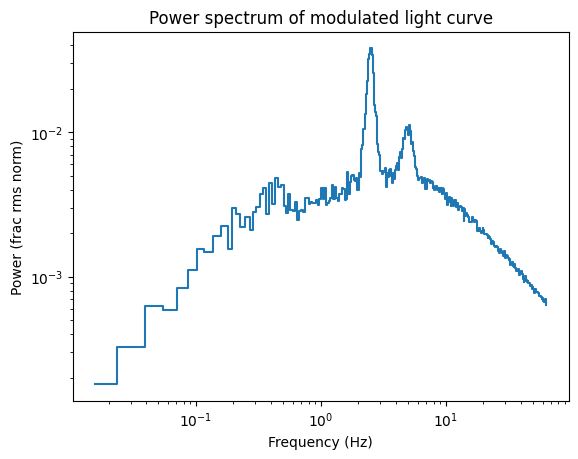

In [11]:
lc_modulated_st = st.Lightcurve(time, lc_modulated, dt=dt)
avg_ps = st.AveragedPowerspectrum.from_lightcurve(lc_modulated_st, 64, norm='frac')
avg_ps = avg_ps.rebin_log(f=0.015)

plt.plot(avg_ps.freq, avg_ps.freq*avg_ps.power, ds='steps-mid')

plt.title('Power spectrum of modulated light curve')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (frac rms norm)')

1.4420325710143078
Q_f: 9.620656145720623
Q_h: 6.129350852677211


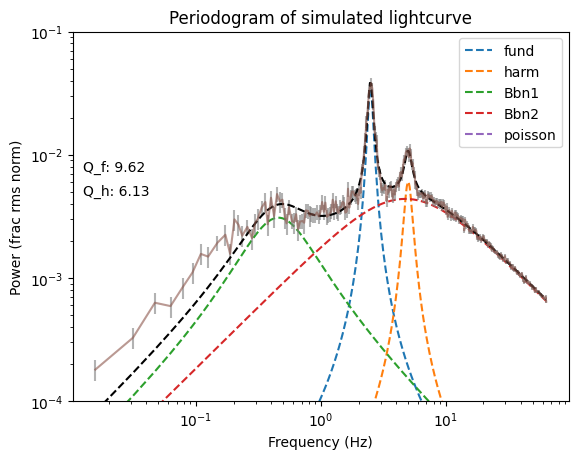

In [12]:
# Fit
full_model = lmfit.Model(lorentz_fwhm, prefix='fund_') + lmfit.Model(lorentz_fwhm, prefix='harm_') + lmfit.Model(lorentz_fwhm, prefix='Bbn1_') + lmfit.Model(lorentz_fwhm, prefix='Bbn2_')  + lmfit.Model(ind_const_model, prefix='poisson_')
params=lmfit.Parameters()

# Initial Parameters for result 1
# params.add('fund_lor_rmssq', value=0.0009, min=0)
# params.add('fund_f_cent', value=2.1, min=0)
# params.add('fund_fwhm', value=.2, min=0)

# params.add('harm_f_cent', expr='2.0*fund_f_cent')
# params.add('harm_lor_rmssq', value=0.003, min=0)
# params.add('harm_fwhm', value=1, min=0)

# params.add('Bbn1_lor_rmssq', value=0.01, min=0)
# params.add('Bbn1_f_cent', value=.3, min=0)
# params.add('Bbn1_fwhm', value=1, min=0)

# params.add('Bbn2_lor_rmssq', value=0.01, min=0)
# params.add('Bbn2_f_cent', value=0, min=0)
# params.add('Bbn2_fwhm', value=10, min=0)

# params.add('poisson_c', value=0.001, min=0)

# Inital Params for Results 2
params.add('fund_lor_rmssq', value=0.009, min=0)
params.add('fund_f_cent', value=2.1, min=0)
params.add('fund_fwhm', value=2, min=0)

params.add('harm_f_cent', expr='2.0*fund_f_cent')
params.add('harm_lor_rmssq', value=0.003, min=0)
params.add('harm_fwhm', value=1, min=0)

params.add('Bbn1_lor_rmssq', value=0.01, min=0)
params.add('Bbn1_f_cent', value=.3, min=0)
params.add('Bbn1_fwhm', value=1, min=0)

params.add('Bbn2_lor_rmssq', value=0.01, min=0)
params.add('Bbn2_f_cent', value=0, min=0)
params.add('Bbn2_fwhm', value=10, min=0)

params.add('poisson_c', value=0.001, min=0)

# fit = fit_powerspec(avg_ps.freq, avg_ps.power, avg_ps.m, model=full_model, params=params, plot_fit=False)
# params=fit.params
# plot_model_dat(avg_ps.freq, avg_ps.power, full_model, params, title=None, save_name=None, sub_poisson_noise=False, ylim=(1e-4, 1e-1), xlim=None)

# plt.plot(avg_ps.freq, full_model.eval(params=params, f=avg_ps.freq) * avg_ps.freq, c='red', ls='-.')
# for mod in full_model.components:
#     model_pow = mod.eval(params, f=avg_ps.freq)
#     plt.plot(avg_ps.freq, (model_pow) * avg_ps.freq, linestyle='-.', label=mod.prefix[:-1])
    
result = lmfit.minimize(obj_fcn2, params, method='nelder', nan_policy='raise', calc_covar=True, args=(avg_ps.freq, avg_ps.power, full_model, avg_ps.m))

for mod in full_model.components:
    model_pow = mod.eval(result.params, f=avg_ps.freq)
    plt.plot(avg_ps.freq, (model_pow) * avg_ps.freq, linestyle='dashed', label=mod.prefix[:-1])

plt.errorbar(avg_ps.freq, avg_ps.power * avg_ps.freq, yerr=avg_ps.power_err*avg_ps.freq, ecolor='grey', alpha=.6)
plt.plot(avg_ps.freq, full_model.eval(params=result.params, f=avg_ps.freq) * avg_ps.freq, c='K'.lower(), ls='dashed')
# plt.axvline(result.params['fund_f_cent'].value + result.params['fund_fwhm'].value)
# plt.axvline(result.params['fund_f_cent'].value - result.params['fund_fwhm'].value)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (frac rms norm)')
plt.ylim(1e-4, 1e-1)
plt.legend()
print(get_chi_sqr(avg_ps.power, full_model.eval(params=result.params, f=avg_ps.freq), avg_ps.power_err, len(avg_ps.power), 12))

Q_f = result.params['fund_f_cent'].value / result.params['fund_fwhm'].value
Q_h = result.params['harm_f_cent'].value / result.params['harm_fwhm'].value

plt.annotate(f'Q_f: {Q_f:.2f}', xy=(.13, .6), xycoords='figure fraction')
plt.annotate(f'Q_h: {Q_h:.2f}', xy=(.13, .55), xycoords='figure fraction')
print('Q_f:', result.params['fund_f_cent'].value / result.params['fund_fwhm'].value)
print('Q_h:', result.params['harm_f_cent'].value / result.params['harm_fwhm'].value)
plt.title('Periodogram of simulated lightcurve')

plt.savefig('C:/Users/shash/UvA/Thesis/Project/MastersThesis/data/processed/20250402_PhaseReconstructionComparison/Parameters_2/PowerSpectrum_2.png')

# Reconstruction method 1

 - Get central frequency, bin using 8 * 1/central freqeuency
 - Calculate phase from one bin, get errors through bootstrapping

In [13]:
def sample_segmented_counts(lc_counts_segmented, n_samples):
    """
    Samples segmented counts, to be used with bootstrapping
    """
    sampled_indices = np.random.choice(len(lc_counts_segmented), n_samples)
    sample = lc_counts_segmented[sampled_indices]
    return sample

def get_phase_errors_bs_m1(lc_segmented_counts, dt, min_bsfreq, max_bsfreq, QPO_fund_freq, n_samples, n_bs_iters, norm='none', pois_correction=False):

    phase_list = []
    for c in range(n_bs_iters):
        sampled_segments = sample_segmented_counts(lc_counts_segmented=lc_segmented_counts, n_samples=n_samples)
        bspec, freq_bspec = avg_bispec(sampled_segments, dt, min_bsfreq, max_bsfreq, norm='none', pois_correction=pois_correction)
        bspec, freq_bspec, ind_bspecs = avg_cross_bispec(sampled_segments, sampled_segments, min_bsfreq, max_bsfreq, dt, norm = 'none', ret_ind_cbs=True)
        # print('Finding freqs:', min_phase_freq, max_phase_freq)
        
        fund_index, discard = get_indices_temp(freq_bspec, QPO_fund_freq, QPO_fund_freq)
        
        # print(freq_bspec)

        phase = np.angle(bspec[fund_index, fund_index])
        phase_list.append(phase)
        
        # break
    
        # Calculate average phase for given sample from range of applicable frequencies
        
    return np.mean(phase_list), np.std(phase_list)

def get_phase_errors_bs_singlebin(lc_segmented_counts, dt, min_bsfreq, max_bsfreq, QPO_fund_freq, n_samples, n_bs_iters, norm='none', pois_correction=False):
    bspec, freq_bspec, bispec_calcs = avg_cross_bispec(lc_segmented_counts, lc_segmented_counts, min_bsfreq, max_bsfreq, dt, norm = 'none', ret_ind_cbs=True)
    
    # print(bispec_calcs.shape)

    angle_list = []
    for c in range(n_bs_iters):
        sample_indices = np.random.randint(0, bispec_calcs.shape[0], size=bispec_calcs.shape[0])

        # Sample cbs to create new population
        sampled_bs = bispec_calcs[sample_indices]
        
        # Take a vector sum over cbs for each energy band
        summed_bs = np.sum(sampled_bs, axis=0)
        # print(summed_bs.shape)
        a = np.angle(summed_bs)

        # a = np.mean(np.diag(np.angle(np.sum(sampled_bs, axis=0)))[fund_index-2: fund_index+2])
        
        fund_index, discard = get_indices_temp(freq_bspec, QPO_fund_freq, QPO_fund_freq)
        angle_list.append(a[fund_index, fund_index])

    angle_list = np.array(angle_list)
    angle_list[angle_list<0] = np.pi*2+angle_list[angle_list<0]
    angle_list[angle_list>2*np.pi] = -(2*np.pi - angle_list[angle_list>2*np.pi])


    theta_p = angle_list.copy()

    calc_central_phase = True
    if calc_central_phase:

        # Re-centering calculated phase
        for _ in range(5):
            theta_mean = np.mean(theta_p[:])

            theta_p[:][theta_p[:]<theta_mean-np.pi] = 2*np.pi + theta_p[:][theta_p[:]<theta_mean-np.pi]
            theta_p[:][theta_p[:]>theta_mean+np.pi] = - (2*np.pi - theta_p[:][theta_p[:]>theta_mean+np.pi])
    

    mean_angle = np.angle(np.sum(bispec_calcs, axis=0))[fund_index, fund_index]
    # mean_angle = np.mean(np.diag(np.angle(np.sum(bispec_calcs, axis=0)))[fund_index-2: fund_index+2])
    std = np.std(theta_p, axis=0)


    # # Plot phase distribution and mean, error
    # plt.hist(theta_p, bins=30)
    # plt.axvline(mean_angle)
    # plt.axvline(mean_angle + std)
    # plt.axvline(mean_angle-std)

    return mean_angle, std

def get_phase_errors_bs_avgoverfwhm(lc_segmented_counts, dt, min_bsfreq, max_bsfreq, QPO_fund_freq, n_samples, n_bs_iters, fwhm, norm='none', pois_correction=False):
    bspec, freq_bspec, bispec_calcs = avg_cross_bispec(lc_segmented_counts, lc_segmented_counts, min_bsfreq, max_bsfreq, dt, norm = 'none', ret_ind_cbs=True)
    
    # print(bispec_calcs.shape)

    angle_list = []
    for c in range(n_bs_iters):
        sample_indices = np.random.randint(0, bispec_calcs.shape[0], size=bispec_calcs.shape[0])

        # Sample cbs to create new population
        sampled_bs = bispec_calcs[sample_indices]
        
        # Take a vector sum over cbs for each energy band
        summed_bs = np.sum(sampled_bs, axis=0)
        # print(summed_bs.shape)
        a = np.angle(summed_bs)
        # # Store calculated energy-dependent cross-biphase
        
        fund_index, discard = get_indices_temp(freq_bspec, QPO_fund_freq, QPO_fund_freq)
        min_index, max_index = get_indices_temp(freq_bspec, QPO_fund_freq - fwhm/2, QPO_fund_freq + fwhm/2)
        # print(freq_bspec[min_index], freq_bspec[max_index])
        angle_list.append(np.mean(np.diag(a)[min_index:max_index]))

        # print(a)
        # print(np.mean(np.diag(a)[min_index:max_index]))

        # plt.plot(freq_bspec, np.diag(a))
        # break

    angle_list = np.array(angle_list)
    angle_list[angle_list<0] = np.pi*2+angle_list[angle_list<0]
    angle_list[angle_list>2*np.pi] = -(2*np.pi - angle_list[angle_list>2*np.pi])


    theta_p = angle_list.copy()

    # print(theta_p)

    calc_central_phase = True
    if calc_central_phase:

        # Re-centering calculated phase
        for _ in range(5):
            theta_mean = np.mean(theta_p[:])

            theta_p[:][theta_p[:]<theta_mean-np.pi] = 2*np.pi + theta_p[:][theta_p[:]<theta_mean-np.pi]
            theta_p[:][theta_p[:]>theta_mean+np.pi] = - (2*np.pi - theta_p[:][theta_p[:]>theta_mean+np.pi])
    

    # mean_angle = np.angle(np.sum(bispec_calcs, axis=0))[fund_index, fund_index]
    mean_angle = np.mean(np.diag(np.angle(np.sum(bispec_calcs, axis=0)))[min_index:max_index])
    std = np.std(theta_p, axis=0)


    # Plot phase distribution and mean, error
    # plt.hist(theta_p, bins=30)
    # plt.hist(angle_list, bins=30)
    # plt.axvline(mean_angle)
    # plt.axvline(mean_angle + std)
    # plt.axvline(mean_angle-std)

    return mean_angle, std
# plt.xlim(1,3)
# print('FIt centre:', result.params['fund_f_cent'].value)

# min_freq = result.params['fund_f_cent'].value - .5*result.params['fund_fwhm'].value
# max_freq = result.params['fund_f_cent'].value + .5*result.params['fund_fwhm'].value
# print('Min and max freqs:', min_freq, max_freq)
# mean_phase, std_phase = get_phase_errors_bs_m1(segmented_counts, dt, .01, 10, min_phase_freq=min_freq, max_phase_freq=max_freq, n_samples=len(segmented_counts), n_bs_iters=50, pois_correction=True)

# plt.pcolor(freq_bspec, freq_bspec, np.abs(bspec), norm='log')
# plt.colorbar()
# plt.show()
# angle = np.angle(avg_cross_bspec)
# # angle[angle<0] = 2*np.pi + angle[angle<0]
# plt.pcolor(freq_bspec, freq_bspec, angle/np.pi,)
# plt.colorbar()

# plt.plot(freq_crossbispec, angle/np.pi[])


In [14]:
bspec_ss = 8 * 1/params_E1['nu_f']
segmented_counts, segmented_times, n = split_multiple_lc(lc_modulated_st.split_by_gti(), bspec_ss, dt=dt)

In [15]:
# mean_phase, std_phase = get_phase_errors_bs_m1(segmented_counts, dt, .01, 10, params_E1['nu_f'],  n_samples=len(segmented_counts), n_bs_iters=100, pois_correction=True)
mean_phase, std_phase = get_phase_errors_bs_singlebin(segmented_counts, dt, .01, 10, params_E1['nu_f'],  n_samples=len(segmented_counts), n_bs_iters=1000, pois_correction=True)
# fwhm = params_E1['nu_f'] / 8
# mean_phase, std_phase = get_phase_errors_bs_avgoverfwhm(segmented_counts, dt, .01, 10, params_E1['nu_f'],  n_samples=len(segmented_counts), n_bs_iters=1000, fwhm=fwhm, pois_correction=False)

In [16]:
print(f'{mean_phase:.2f} ± {std_phase:.2f}')
print(params_E1['psi'])

-1.48 ± 0.06
-1.5707963267948966


## Wrapper for phase variations

In [74]:
def wrapper_phase_vars(mod_params, pspar):
    # pspar = pspars[0]
    lc = simlc(dt, ntimes, expquery, rms, psmodel, pspar)

    # To convert lc to 1s
    # lc = lc/lc
    lc *= 6000 * dt
    # lc = lc**2


    time = np.linspace(start=dt, stop=(dt*ntimes), num=ntimes) # Set up times for plotting
    minfreq = 1./(ntimes*dt)
    freq = np.linspace(start=minfreq,stop=(minfreq*ntimes//2), num=ntimes//2)

    # plt.figure()
    # plt.plot(time, lc)
    # plt.title('Initial Light Curve')
    # plt.show()

    # plt.figure()
    # plt.plot(freq,freq*psmodel(freq,*pspar))
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.title('Input Model Power Spectrum')
    # plt.show()
    
    a0 = 0.013 # 0.0081 # 0.001 # 0.0001 # 0.00001 
    nu0 = 0
    hwhm = 0.2

    n_samples = len(time) 
    phi_stoch = np.cumsum(gen_stochastic_phi(a0=a0, hwhm=hwhm, nu0=nu0, dt=dt, ntimes=ntimes) - 1)

    # Modulate light curve using specified params

    lc_modulated = modulate_lc(lc_times=time, lc_counts=lc, params=mod_params, phi_stoch=phi_stoch)
    # lc_modulated = np.random.poisson(lc_modulated)
    # plt.plot(time, lc_modulated)
    # plt.xlim(0,30)
    # plt.show()
    
    lc_modulated_st = st.Lightcurve(time, lc_modulated, dt=dt)
    avg_ps = st.AveragedPowerspectrum.from_lightcurve(lc_modulated_st, 32, norm='frac')
    avg_ps = avg_ps.rebin_log(f=0.02)
    
    # plt.plot(avg_ps.freq, avg_ps.freq*avg_ps.power, ds='steps-mid')

    # plt.title('Power spectrum of modulated light curve')
    # plt.xscale('log')
    # plt.yscale('log')
    # plt.xlabel('Frequency (Hz)')
    # plt.ylabel('Power (frac rms norm)')
    # plt.show()
    bspec_ss = 8 * 1/mod_params['nu_f']
    segmented_counts, segmented_times, n = split_multiple_lc(lc_modulated_st.split_by_gti(), bspec_ss, dt=dt)
    mean_phase, std_phase = get_phase_errors_bs_singlebin(segmented_counts, dt, .01, 10, params_E1['nu_f'],  n_samples=len(segmented_counts), n_bs_iters=1000, pois_correction=False)
    # mean_phase, std_phase = get_phase_errors_bs_avgoverfwhm(segmented_counts, dt, .01, 10, params_E1['nu_f'],  n_samples=len(segmented_counts), n_bs_iters=1000, fwhm=mod_params['nu_f']/8, pois_correction=False)
    # plt.show()
    return mean_phase, std_phase
# wrapper_phase_vars(params_E1, pspars[0])

## Representative Power Spectrum

c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\stingray\lightcurve.py:329: UserWarning: On Windows, the size of an integer is 32 bits. To avoid integer overflow, I'm converting the input array to float
  warnings.warn(


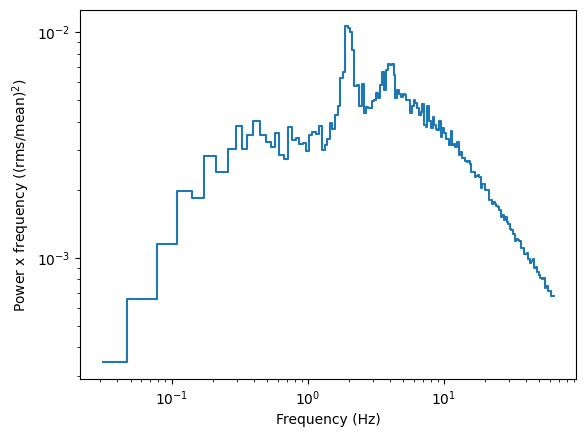

In [157]:
params_E1 = {'A1': 0.05,
                'A2': 0.03,
                'psi': -.5*np.pi,
                'phi_0':0,
                'nu_f': 2,
                'nu_h': 4}
lc = simlc(dt, ntimes, expquery, rms, psmodel, pspars[0])

# To convert lc to 1s
# lc = lc/lc
lc *= 6000 * dt
# lc = lc**2


time = np.linspace(start=dt, stop=(dt*ntimes), num=ntimes) # Set up times for plotting
minfreq = 1./(ntimes*dt)
freq = np.linspace(start=minfreq,stop=(minfreq*ntimes//2), num=ntimes//2)

# plt.figure()
# plt.plot(time, lc)
# plt.title('Initial Light Curve')
# plt.show()

# plt.figure()
# plt.plot(freq,freq*psmodel(freq,*pspar))
# plt.yscale('log')
# plt.xscale('log')
# plt.title('Input Model Power Spectrum')
# plt.show()

a0 = 0.013 # 0.0081 # 0.001 # 0.0001 # 0.00001 
nu0 = 0
hwhm = 0.2

n_samples = len(time) 
phi_stoch = np.cumsum(gen_stochastic_phi(a0=a0, hwhm=hwhm, nu0=nu0, dt=dt, ntimes=ntimes) - 1)

# Modulate light curve using specified params

lc_modulated = modulate_lc(lc_times=time, lc_counts=lc, params=params_E1, phi_stoch=phi_stoch)
# lc_modulated = np.random.poisson(lc_modulated)
# plt.plot(time, lc_modulated)
# plt.xlim(0,30)
# plt.show()

lc_modulated_st = st.Lightcurve(time, lc_modulated, dt=dt)
avg_ps = st.AveragedPowerspectrum.from_lightcurve(lc_modulated_st, 32, norm='frac')
avg_ps = avg_ps.rebin_log(f=0.025)
plt.plot(avg_ps.freq, avg_ps.freq*avg_ps.power, ds='steps-mid')

# plt.title('Power spectrum of modulated light curve')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(f'Power x frequency ((rms/mean)$^2$)')
plt.savefig(f'{save_dir}/RepPspec_StrongBBn.pdf', dpi=600)
plt.show()

c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\stingray\lightcurve.py:329: UserWarning: On Windows, the size of an integer is 32 bits. To avoid integer overflow, I'm converting the input array to float
  warnings.warn(
c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\stingray\lightcurve.py:329: UserWarning: On Windows, the size of an integer is 32 bits. To avoid integer overflow, I'm converting the input array to float
  warnings.warn(
c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\stingray\lightcurve.py:329: UserWarning: On Windows, the size of an integer is 32 bits. To avoid integer overflow, I'm converting the input array to float
  warnings.warn(
c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\stingray\lightcurve.py:329: UserWarning: On Windows, the size of an integer is 32 bits. To avoid integer overflow, I'm converting the input array to float
  warnings.warn(
c:\Users\shash\UvA\Thesi

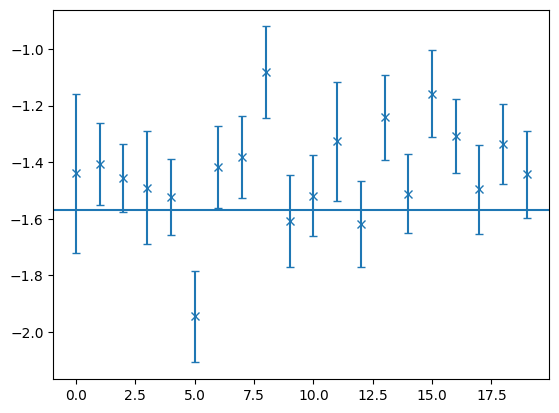

In [125]:
# phase_extracted = []
# std_extracted = []
# inp_psi_ls = [-.8*np.pi, -.5 * np.pi, -.3*np.pi, 0, 0.3*np.pi,  0.5*np.pi, 0.8*np.pi]
# for psi in inp_psi_ls:
    
#     params_E1 = {'A1': 0.05,
#                 'A2': 0.03,
#                 'psi': psi,
#                 'phi_0':0,
#                 'nu_f': nu_f,
#                 'nu_h': nu_h}
#     p,s = wrapper_phase_vars(params_E1, pspars[0])
#     phase_extracted.append(p)
#     std_extracted.append(s)

# plt.errorbar(inp_psi_ls, phase_extracted, yerr=std_extracted, ls='', marker='x')
# plt.plot(inp_psi_ls, inp_psi_ls)


phase_extracted = []
std_extracted = []
for c in range(20):
    
    params_E1 = {'A1': 0.05,
                'A2': 0.03,
                'psi': -.5*np.pi,
                'phi_0':0,
                'nu_f': 2,
                'nu_h': 4}
    p, s = wrapper_phase_vars(params_E1, pspars[0])
    phase_extracted.append(p)
    std_extracted.append(s)

plt.errorbar(range(20), phase_extracted, yerr=std_extracted, ls='', marker='x', capsize=3)
plt.axhline(params_E1['psi'])


In [18]:
paper_dir = '../../paper/'
data_dir = '../../data/'
save_dir = f'{paper_dir}Figures/PhaseReconstruction/'
save_dir_arrs =  f'{data_dir}processed/04072025_PhaseReconstruction/'

[np.float64(-1.4397787152550479), np.float64(-1.406918772476814), np.float64(-1.4546921074032566), np.float64(-1.4905207435208367), np.float64(-1.5233020569767814), np.float64(-1.9452453849149185), np.float64(-1.4168010020386947), np.float64(-1.3829476705353811), np.float64(-1.0816495600372125), np.float64(-1.6072140715977776), np.float64(-1.5181337672579303), np.float64(-1.3263169198107), np.float64(-1.6187798382925733), np.float64(-1.242125770837029), np.float64(-1.511151215917083), np.float64(-1.1577202800119124), np.float64(-1.3074179267926755), np.float64(-1.4963561311647477), np.float64(-1.3369967255027753), np.float64(-1.4430824378801763)]
-1.4353575549112159 0.17777445713212356


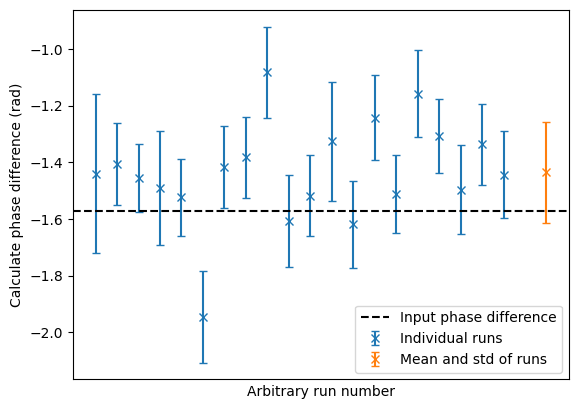

In [126]:
plt.errorbar(range(20), phase_extracted, yerr=std_extracted, ls='', marker='x', capsize=3, label='Individual runs')
plt.axhline(params_E1['psi'], c='k', ls='dashed', label='Input phase difference')
plt.xticks([])
plt.ylabel('Calculate phase difference (rad)')
# plt.ylim(1.56, 1.58)
print(phase_extracted)

print(np.mean(phase_extracted), np.std(phase_extracted))
plt.errorbar(21, np.mean(phase_extracted), yerr=np.std(phase_extracted), ls='', marker='x', capsize=3, label='Mean and std of runs')
plt.xlabel('Arbitrary run number')
plt.legend(loc='lower right')
# plt.savefig(f'{save_dir}/psi_{params_E1["psi"]:.1f}_strongBBN_.pdf', dpi=600)

phase_extracted = np.array(phase_extracted)
std_extracted = np.array(std_extracted)

# plt.ylim(1,2)

np.savez(f'{save_dir_arrs}singlebin_psi_{params_E1["psi"]:.1f}_strongBBN_20runs', ext_phase=phase_extracted, ext_std = std_extracted)

Text(0, 0.5, 'Calculated phase difference (rad)')

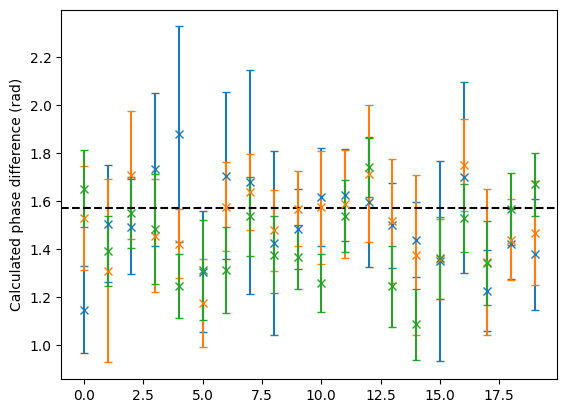

In [541]:
# load_from = f'{save_dir_arrs}avgoverfwhm_psi_{params_E1["psi"]:.1f}_strongBBN_20runs_factor25.npz'

# f = np.load(load_from)
# extracted_phase = f['ext_phase']
# extracted_std = f['ext_std']

# plt.errorbar(range(20), extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label='Individual runs')

load_from = f'{save_dir_arrs}avgoverfwhm_psi_{params_E1["psi"]:.1f}_strongBBN_20runs_factor12.npz'

f = np.load(load_from)
extracted_phase = f['ext_phase']
extracted_std = f['ext_std']

plt.errorbar(range(20), extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label='Individual runs')

# load_from = f'{save_dir_arrs}avgoverfwhm_psi_{params_E1["psi"]:.1f}_strongBBN_20runs_factor15.npz'

# f = np.load(load_from)
# extracted_phase = f['ext_phase']
# extracted_std = f['ext_std']

# plt.errorbar(range(20), extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label='Individual runs')

load_from = f'{save_dir_arrs}singlebin_psi_{params_E1["psi"]:.1f}_strongBBN_20runs_factor12.npz'

f = np.load(load_from)
extracted_phase = f['ext_phase']
extracted_std = f['ext_std']

plt.errorbar(range(20), extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label='Individual runs')

load_from = f'{save_dir_arrs}singlebin_psi_{params_E1["psi"]:.1f}_strongBBN_20runs.npz'

f = np.load(load_from)
extracted_phase = f['ext_phase']
extracted_std = f['ext_std']

plt.errorbar(range(20), extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label='Individual runs')

plt.axhline(params_E1["psi"], c='k', ls='--', label='Expected phase difference')
plt.ylabel('Calculated phase difference (rad)')

## Plotting from saved results

### Compraing fwhm vs single bin for a fixed bin width

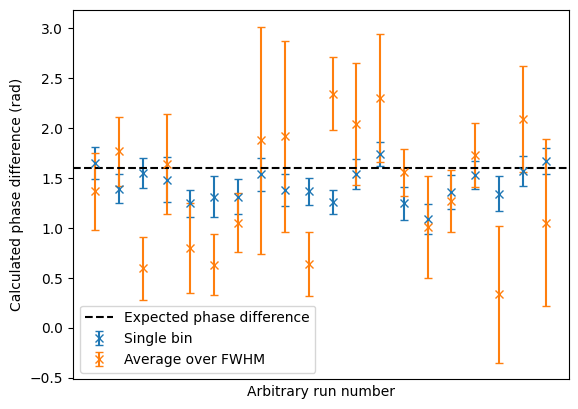

In [21]:
psi=1.6
load_from = f'{save_dir_arrs}singlebin_psi_{psi:.1f}_strongBBN_20runs.npz'

f = np.load(load_from)
extracted_phase = f['ext_phase']
extracted_std = f['ext_std']

plt.errorbar(range(20), extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label='Single bin')

load_from = f'{save_dir_arrs}avgoverfwhm_psi_{psi:.1f}_strongBBN_20runs.npz'

f = np.load(load_from)
extracted_phase = f['ext_phase']
extracted_std = f['ext_std']

plt.errorbar(range(20), extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label='Average over FWHM')

plt.axhline(psi, c='k', ls='--', label='Expected phase difference')
plt.legend()
plt.ylabel('Calculated phase difference (rad)')
plt.xlabel('Arbitrary run number')
plt.xticks([])
plt.savefig(f'{save_dir}/FWHM_vs_singlebin_samebw.pdf', dpi=600)

### FWHM for different bin widths

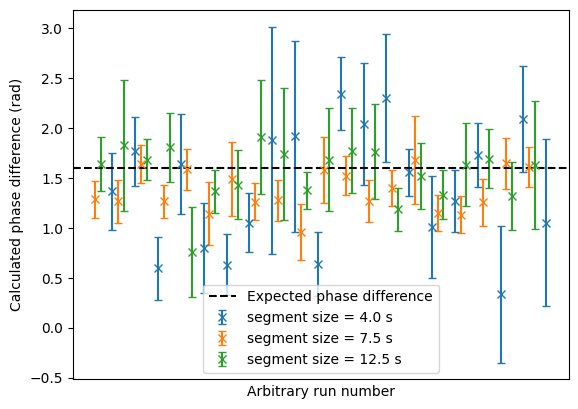

In [567]:
psi=1.6
load_from = f'{save_dir_arrs}avgoverfwhm_psi_{psi:.1f}_strongBBN_20runs.npz'

f = np.load(load_from)
extracted_phase = f['ext_phase']
extracted_std = f['ext_std']

plt.errorbar(4*np.array(range(20))+3, extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label=f'segment size = {8*1/2} s')

# load_from = f'{save_dir_arrs}avgoverfwhm_psi_{psi:.1f}_strongBBN_20runs_factor12.npz'

# f = np.load(load_from)
# extracted_phase = f['ext_phase']
# extracted_std = f['ext_std']

# plt.errorbar(4*np.array(range(20))+2, extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label=f'segment size = {12*1/2} s')

load_from = f'{save_dir_arrs}avgoverfwhm_psi_{psi:.1f}_strongBBN_20runs_factor15.npz'

f = np.load(load_from)
extracted_phase = f['ext_phase']
extracted_std = f['ext_std']

plt.errorbar(4*np.array(range(20)), extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label=f'segment size = {15*1/2} s')

load_from = f'{save_dir_arrs}avgoverfwhm_psi_{psi:.1f}_strongBBN_20runs_factor25.npz'

f = np.load(load_from)
extracted_phase = f['ext_phase']
extracted_std = f['ext_std']

plt.errorbar(4*np.array(range(20))+1, extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label=f'segment size = {25*1/2} s')


plt.axhline(psi, c='k', ls='--', label='Expected phase difference')
plt.legend()
plt.ylabel('Calculated phase difference (rad)')
plt.xlabel('Arbitrary run number')
plt.xticks([])

plt.savefig(f'{save_dir}/FWHM_differentsegmentsizes.pdf', dpi=600)

### Comparing best fwhm segment size vs single bin

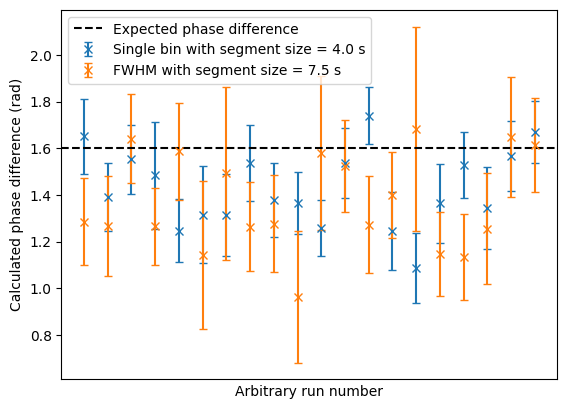

In [568]:
load_from = f'{save_dir_arrs}singlebin_psi_{psi:.1f}_strongBBN_20runs.npz'

f = np.load(load_from)
extracted_phase = f['ext_phase']
extracted_std = f['ext_std']

plt.errorbar(range(20), extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label=f'Single bin with segment size = {8*1/2} s')

load_from = f'{save_dir_arrs}avgoverfwhm_psi_{psi:.1f}_strongBBN_20runs_factor15.npz'

f = np.load(load_from)
extracted_phase = f['ext_phase']
extracted_std = f['ext_std']

plt.errorbar(range(20), extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label=f'FWHM with segment size = {15*1/2} s')


plt.axhline(psi, c='k', ls='--', label='Expected phase difference')
plt.legend()
plt.ylabel('Calculated phase difference (rad)')
plt.xlabel('Arbitrary run number')
plt.xticks([])

plt.savefig(f'{save_dir}/FWHM_vs_singlebin_differentbw.pdf', dpi=600)

## Fitting for bias testing

In [22]:
import lmfit

#### $\psi=\pi/2$

Fit value: 1.44 ± 0.04
Chi sq: 26.40 for 19 dof
Goodness of fit: 0.120


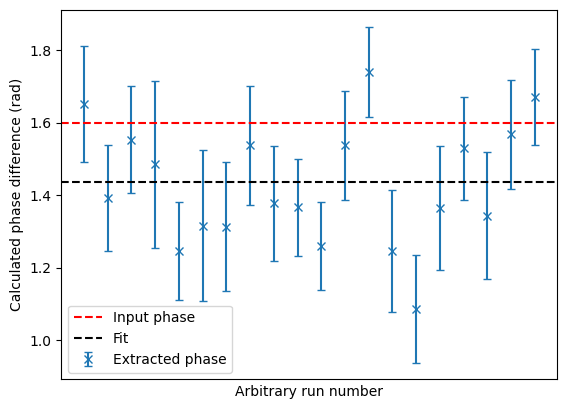

In [142]:
psi=1.6
load_from = f'{save_dir_arrs}singlebin_psi_{psi:.1f}_strongBBN_20runs.npz'

f = np.load(load_from)
extracted_phase = f['ext_phase']
extracted_std = f['ext_std']

plt.errorbar(range(20), extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label='Extracted phase')

mod = lmfit.models.ConstantModel()
pars = mod.guess(extracted_phase, x=range(20))
out = mod.fit(extracted_phase, pars, x=range(20), weights=1/extracted_std)

# print(out.fit_report())
# plt.axhline(out.params['c'].value)

mod_y = np.ones(len(extracted_phase)) * out.params['c'].value
print(f"Fit value: {out.params['c'].value:.2f} ± {out.params['c'].stderr:.2f}")
print(f'Chi sq: {out.chisqr:.2f} for {out.nfree} dof')
# print(get_chi_sqr(dat_y=extracted_phase, mod_y=mod_y, err_y=extracted_std, n_datpoints=len(extracted_phase), n_free=1))
print(f'Goodness of fit: {scipy.stats.chi2.sf(out.chisqr, df=out.nfree):.3f}')

plt.axhline(psi, label='Input phase', ls='--', c='r')
plt.axhline(out.params['c'].value, label='Fit', ls='--', c='k')
plt.legend()
plt.ylabel('Calculated phase difference (rad)')
plt.xlabel('Arbitrary run number')
plt.xticks([])
plt.legend()

plt.savefig(f'{save_dir}/PhaseBias_psi1.6.pdf', dpi=600)

#### $\psi=0$

Fit value: 0.02 ± 0.03
Chi sq: 24.97 for 19 dof
Goodness of fit: 0.162


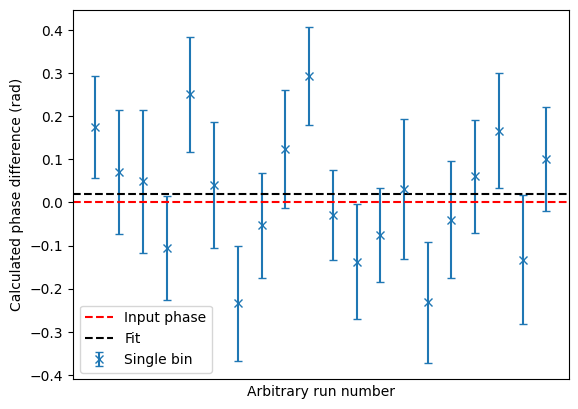

In [143]:
psi=0
load_from = f'{save_dir_arrs}singlebin_psi_{psi:.1f}_strongBBN_20runs.npz'

f = np.load(load_from)
extracted_phase = f['ext_phase']
extracted_std = f['ext_std']

plt.errorbar(range(20), extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label='Single bin')

mod = lmfit.models.ConstantModel()
pars = mod.guess(extracted_phase, x=range(20))
out = mod.fit(extracted_phase, pars, x=range(20), weights=1/extracted_std)

# print(out.fit_report())
# plt.axhline(out.params['c'].value)

mod_y = np.ones(len(extracted_phase)) * out.params['c'].value
print(f"Fit value: {out.params['c'].value:.2f} ± {out.params['c'].stderr:.2f}")
print(f'Chi sq: {out.chisqr:.2f} for {out.nfree} dof')
# print(get_chi_sqr(dat_y=extracted_phase, mod_y=mod_y, err_y=extracted_std, n_datpoints=len(extracted_phase), n_free=1))
print(f'Goodness of fit: {scipy.stats.chi2.sf(out.chisqr, df=out.nfree):.3f}')

plt.axhline(psi, label='Input phase', ls='--', c='r')
plt.axhline(out.params['c'].value, label='Fit', ls='--', c='k')
plt.legend()
plt.ylabel('Calculated phase difference (rad)')
plt.xlabel('Arbitrary run number')
plt.xticks([])
plt.legend()
plt.savefig(f'{save_dir}/PhaseBias_psi0.pdf', dpi=600)

#### $\psi=-\pi/2$

Fit value: -1.43 ± 0.04
Chi sq: 25.33 for 19 dof
Goodness of fit: 0.150


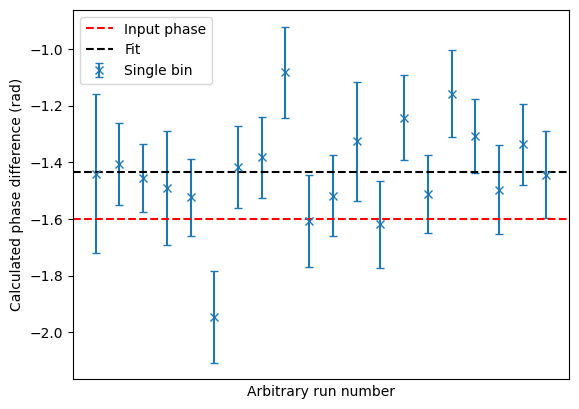

In [145]:
psi=-1.6
load_from = f'{save_dir_arrs}singlebin_psi_{psi:.1f}_strongBBN_20runs.npz'

f = np.load(load_from)
extracted_phase = f['ext_phase']
extracted_std = f['ext_std']

plt.errorbar(range(20), extracted_phase, yerr=extracted_std, ls='', marker='x', capsize=3, label='Single bin')

mod = lmfit.models.ConstantModel()
pars = mod.guess(extracted_phase, x=range(20))
out = mod.fit(extracted_phase, pars, x=range(20), weights=1/extracted_std)

# print(out.fit_report())

mod_y = np.ones(len(extracted_phase)) * out.params['c'].value
print(f"Fit value: {out.params['c'].value:.2f} ± {out.params['c'].stderr:.2f}")
print(f'Chi sq: {out.chisqr:.2f} for {out.nfree} dof')
# print(get_chi_sqr(dat_y=extracted_phase, mod_y=mod_y, err_y=extracted_std, n_datpoints=len(extracted_phase), n_free=1))
print(f'Goodness of fit: {scipy.stats.chi2.sf(out.chisqr, df=out.nfree):.3f}')

plt.axhline(psi, label='Input phase', ls='--', c='r')
plt.axhline(out.params['c'].value, label='Fit', ls='--', c='k')
plt.legend()
plt.ylabel('Calculated phase difference (rad)')
plt.xlabel('Arbitrary run number')
plt.xticks([])
plt.legend()
plt.savefig(f'{save_dir}/PhaseBias_psi-1.6.pdf', dpi=600)
plt.show()

# plt.axhline(-1.6)

# Cross Bispectrum

In [158]:
def get_phase_errors_bs_singlebin_csb(lc_segmented_counts_ref, lc_segmented_counts_sub, dt, min_bsfreq, max_bsfreq, QPO_fund_freq, n_samples, n_bs_iters, norm='none', pois_correction=False):
    bspec, freq_bspec, bispec_calcs = avg_cross_bispec(lc_segmented_counts_ref, lc_segmented_counts_sub, min_bsfreq, max_bsfreq, dt, norm = 'none', ret_ind_cbs=True)

    angle_list = []
    for c in range(n_bs_iters):
        sample_indices = np.random.randint(0, bispec_calcs.shape[0], size=bispec_calcs.shape[0])

        # Sample cbs to create new population
        sampled_bs = bispec_calcs[sample_indices]
        
        # Take a vector sum over cbs for each energy band
        summed_bs = np.sum(sampled_bs, axis=0)
        # print(summed_bs.shape)
        a = np.angle(summed_bs)

        # a = np.mean(np.diag(np.angle(np.sum(sampled_bs, axis=0)))[fund_index-2: fund_index+2])
        
        fund_index, discard = get_indices_temp(freq_bspec, QPO_fund_freq, QPO_fund_freq)
        angle_list.append(a[fund_index, fund_index])

    angle_list = np.array(angle_list)
    angle_list[angle_list<0] = np.pi*2+angle_list[angle_list<0]
    angle_list[angle_list>2*np.pi] = -(2*np.pi - angle_list[angle_list>2*np.pi])


    theta_p = angle_list.copy()

    calc_central_phase = True
    if calc_central_phase:

        # Re-centering calculated phase
        for _ in range(5):
            theta_mean = np.mean(theta_p[:])

            theta_p[:][theta_p[:]<theta_mean-np.pi] = 2*np.pi + theta_p[:][theta_p[:]<theta_mean-np.pi]
            theta_p[:][theta_p[:]>theta_mean+np.pi] = - (2*np.pi - theta_p[:][theta_p[:]>theta_mean+np.pi])
    

    mean_angle = np.angle(np.sum(bispec_calcs, axis=0))[fund_index, fund_index]
    # mean_angle = np.mean(np.diag(np.angle(np.sum(bispec_calcs, axis=0)))[fund_index-2: fund_index+2])
    std = np.std(theta_p, axis=0)


    # # Plot phase distribution and mean, error
    # plt.hist(theta_p, bins=30)
    # plt.axvline(mean_angle)
    # plt.axvline(mean_angle + std)
    # plt.axvline(mean_angle-std)

    return mean_angle, std

def get_phase_errors_bs_avgoverfwhm_cbs(lc_segmented_counts_ref, lc_segmented_counts_sub, dt, min_bsfreq, max_bsfreq, QPO_fund_freq, n_samples, n_bs_iters, fwhm, norm='none', pois_correction=False):
    bspec, freq_bspec, bispec_calcs = avg_cross_bispec(lc_segmented_counts_ref, lc_segmented_counts_sub, min_bsfreq, max_bsfreq, dt, norm = 'none', ret_ind_cbs=True)

    angle_list = []
    for c in range(n_bs_iters):
        sample_indices = np.random.randint(0, bispec_calcs.shape[0], size=bispec_calcs.shape[0])

        # Sample cbs to create new population
        sampled_bs = bispec_calcs[sample_indices]
        
        # Take a vector sum over cbs for each energy band
        summed_bs = np.sum(sampled_bs, axis=0)
        # print(summed_bs.shape)
        a = np.angle(summed_bs)
        # # Store calculated energy-dependent cross-biphase
        
        fund_index, discard = get_indices_temp(freq_bspec, QPO_fund_freq, QPO_fund_freq)
        min_index, max_index = get_indices_temp(freq_bspec, QPO_fund_freq - fwhm/2, QPO_fund_freq + fwhm/2)
        # print(freq_bspec[min_index], freq_bspec[max_index])
        angle_list.append(np.mean(np.diag(a)[min_index:max_index]))

        # print(a)
        # print(np.mean(np.diag(a)[min_index:max_index]))

        # plt.plot(freq_bspec, np.diag(a))
        # break

    angle_list = np.array(angle_list)
    angle_list[angle_list<0] = np.pi*2+angle_list[angle_list<0]
    angle_list[angle_list>2*np.pi] = -(2*np.pi - angle_list[angle_list>2*np.pi])


    theta_p = angle_list.copy()

    # print(theta_p)

    calc_central_phase = True
    if calc_central_phase:

        # Re-centering calculated phase
        for _ in range(5):
            theta_mean = np.mean(theta_p[:])

            theta_p[:][theta_p[:]<theta_mean-np.pi] = 2*np.pi + theta_p[:][theta_p[:]<theta_mean-np.pi]
            theta_p[:][theta_p[:]>theta_mean+np.pi] = - (2*np.pi - theta_p[:][theta_p[:]>theta_mean+np.pi])
    

    # mean_angle = np.angle(np.sum(bispec_calcs, axis=0))[fund_index, fund_index]
    mean_angle = np.mean(np.diag(np.angle(np.sum(bispec_calcs, axis=0)))[min_index:max_index])
    std = np.std(theta_p, axis=0)


    # Plot phase distribution and mean, error
    # plt.hist(theta_p, bins=30)
    # plt.hist(angle_list, bins=30)
    # plt.axvline(mean_angle)
    # plt.axvline(mean_angle + std)
    # plt.axvline(mean_angle-std)

    return mean_angle, std

In [ ]:
def wrapper_phase_vars_cbs(mod_params, pspar):
    # pspar = pspars[0]
    lc = simlc(dt, ntimes, expquery, rms, psmodel, pspar)

    # To convert lc to 1s
    # lc = lc/lc
    lc *= 6000 * dt
    # lc = lc**2


    time = np.linspace(start=dt, stop=(dt*ntimes), num=ntimes) # Set up times for plotting
    minfreq = 1./(ntimes*dt)
    freq = np.linspace(start=minfreq,stop=(minfreq*ntimes//2), num=ntimes//2)

    # plt.figure()
    # plt.plot(time, lc)
    # plt.title('Initial Light Curve')
    # plt.show()

    # plt.figure()
    # plt.plot(freq,freq*psmodel(freq,*pspar))
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.title('Input Model Power Spectrum')
    # plt.show()
    
    a0 = 0.013 # 0.0081 # 0.001 # 0.0001 # 0.00001 
    nu0 = 0
    hwhm = 0.2

    n_samples = len(time) 
    phi_stoch = np.cumsum(gen_stochastic_phi(a0=a0, hwhm=hwhm, nu0=nu0, dt=dt, ntimes=ntimes) - 1)

    # Modulate light curve using specified params

    lc_modulated = modulate_lc(lc_times=time, lc_counts=lc, params=mod_params, phi_stoch=phi_stoch)
    # lc_modulated = np.random.poisson(lc_modulated)
    # plt.plot(time, lc_modulated)
    # plt.xlim(0,30)
    # plt.show()
    
    lc_modulated_st = st.Lightcurve(time, lc_modulated, dt=dt)
    avg_ps = st.AveragedPowerspectrum.from_lightcurve(lc_modulated_st, 32, norm='frac')
    avg_ps = avg_ps.rebin_log(f=0.02)
    
    # plt.plot(avg_ps.freq, avg_ps.freq*avg_ps.power, ds='steps-mid')

    # plt.title('Power spectrum of modulated light curve')
    # plt.xscale('log')
    # plt.yscale('log')
    # plt.xlabel('Frequency (Hz)')
    # plt.ylabel('Power (frac rms norm)')
    # plt.show()
    bspec_ss = 8 * 1/mod_params['nu_f']
    segmented_counts, segmented_times, n = split_multiple_lc(lc_modulated_st.split_by_gti(), bspec_ss, dt=dt)
    mean_phase, std_phase = get_phase_errors_bs_singlebin(segmented_counts, dt, .01, 10, params_E1['nu_f'],  n_samples=len(segmented_counts), n_bs_iters=1000, pois_correction=False)
    # mean_phase, std_phase = get_phase_errors_bs_avgoverfwhm(segmented_counts, dt, .01, 10, params_E1['nu_f'],  n_samples=len(segmented_counts), n_bs_iters=1000, fwhm=mod_params['nu_f']/8, pois_correction=False)
    # plt.show()
    return mean_phase, std_phase
# wrapper_phase_vars(params_E1, pspars[0])

# Method 2

FIt centre: 2.0023049186586666
Min and max freqs: 1.843402107409134 2.161207729908199


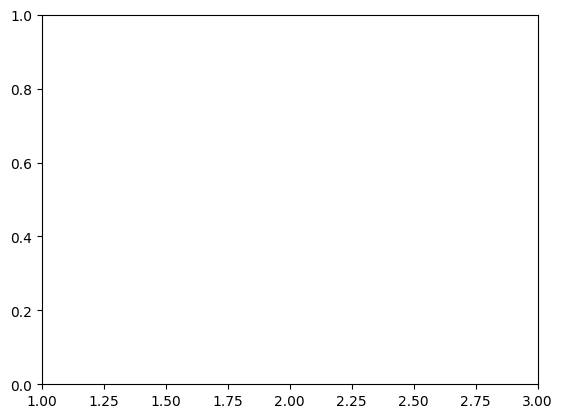

In [ ]:
def get_phase_errors_bs(lc_segmented_counts, dt, min_bsfreq, max_bsfreq, min_phase_freq, max_phase_freq, n_samples, n_bs_iters, norm='none', pois_correction=False):

    phase_list = []
    for c in range(n_bs_iters):
        sampled_segments = sample_segmented_counts(lc_counts_segmented=lc_segmented_counts, n_samples=n_samples)
        bspec, freq_bspec = avg_bispec(sampled_segments, dt, min_bsfreq, max_bsfreq, norm='none', pois_correction=pois_correction)
        
        min_index, max_index = get_indices_temp(freq_bspec, min_phase_freq, max_phase_freq)

        phase = np.mean(np.angle(np.diag(bspec)[min_index:max_index]))
        phase_list.append(phase)
            
    return np.mean(phase_list), np.std(phase_list)
plt.xlim(1,3)
print('Fit centre:', result.params['fund_f_cent'].value)

min_freq = result.params['fund_f_cent'].value - .5*result.params['fund_fwhm'].value
max_freq = result.params['fund_f_cent'].value + .5*result.params['fund_fwhm'].value
print('Min and max freqs:', min_freq, max_freq)


bspec_ss = 64
segmented_counts, segmented_times, n = split_multiple_lc(lc_modulated_st.split_by_gti(), bspec_ss, dt=dt)

mean_phase, std_phase = get_phase_errors_bs(segmented_counts, dt, .01, 10, min_phase_freq=min_freq, max_phase_freq=max_freq, n_samples=len(segmented_counts), n_bs_iters=25, pois_correction=True)

# plt.pcolor(freq_bspec, freq_bspec, np.abs(bspec), norm='log')
# plt.colorbar()
# plt.show()
# angle = np.angle(avg_cross_bspec)
# # angle[angle<0] = 2*np.pi + angle[angle<0]
# plt.pcolor(freq_bspec, freq_bspec, angle/np.pi,)
# plt.colorbar()

# plt.plot(freq_crossbispec, angle/np.pi[])


In [191]:
print(mean_phase, std_phase)
print(params_E1['psi'])

1.5580892890682905 0.17674489929806173
1.5707963267948966


In [21]:
def phase_from_bspecs(bispec_arr, frequencies, phase_freq_min, phase_freq_max, N_pois_correction=0):
    """
    From a list containing n bispectra, calculate an average bispectrum from which an average biphase can be calculated.
    """
    print(bispec_arr.shape)
    
    min_index, max_index = get_indices_temp(frequencies, phase_freq_min, phase_freq_max)
    print(min_index, max_index)
    phase_list = []
    for bspec in bispec_arr:
        avg_bspec = np.mean(np.diag(bspec)[min_index:max_index]) + 2*N_pois_correction
        phase = np.angle(avg_bspec)
        # phase = np.mean(np.angle(np.diag(bspec)[min_index:max_index]))
        phase_list.append(phase)
    # plt.hist(phase_list, bins=30)
    return np.mean(phase_list), np.std(phase_list)

In [22]:
bspec_arr,freqs, N_pois_correction = gen_bispectra_bootstrapping(lc_counts_list=segmented_counts, dt=dt, min_freq=0.01, max_freq=10, norm='none', pois_correction=True)

In [23]:
# plt.axvline(result.params['fund_f_cent'].value + result.params['fund_fwhm'].value)
# plt.axvline(result.params['fund_f_cent'].value - result.params['fund_fwhm'].value)
a,b=phase_from_bspecs(bspec_arr, freqs, result.params['fund_f_cent'].value - result.params['fund_fwhm'].value, result.params['fund_f_cent'].value + result.params['fund_fwhm'].value)

(32, 639, 639)
107 147


In [24]:
print(a,b)

0.7163264346412884 1.6940054874893555


# Throw both methods into a for loop

Working on ss= 2
Completed method 1


c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Completed method 2
Working on ss= 4
Completed method 1
Completed method 2
Working on ss= 5.0
Completed method 1
Completed method 2
Working on ss= 8
Completed method 1
Completed method 2
Working on ss= 16
Completed method 1
Completed method 2
Working on ss= 32
Completed method 1
Completed method 2
Working on ss= 64
Completed method 1
Completed method 2


<ErrorbarContainer object of 3 artists>

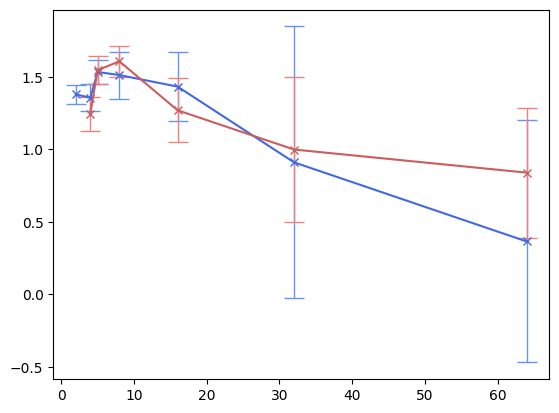

In [25]:
ss_list = [2, 4, 10*1/2, 8, 16, 32, 64]
method_1_phase = []
method_2_phase = []
method_1_errs = []
method_2_errs = []

for ss in ss_list:
    print('Working on ss=', ss)
    # Method one:
    segmented_counts, segmented_times, n = split_multiple_lc(lc_modulated_st.split_by_gti(), ss, dt=dt)
    
    mean_phase, std_phase = get_phase_errors_bs_m1(segmented_counts, dt, .01, 10, params_E1['nu_f'],  n_samples=len(segmented_counts), n_bs_iters=50, pois_correction=True)
    
    method_1_phase.append(mean_phase)
    method_1_errs.append(std_phase)
    print('Completed method 1')
    
    # Method 2
    min_freq = result.params['fund_f_cent'].value - .5*result.params['fund_fwhm'].value
    max_freq = result.params['fund_f_cent'].value + .5*result.params['fund_fwhm'].value
    mean_phase, std_phase = get_phase_errors_bs(segmented_counts, dt, .01, 10, min_phase_freq=min_freq, max_phase_freq=max_freq, n_samples=len(segmented_counts), n_bs_iters=50, pois_correction=True)
    print('Completed method 2')
    method_2_phase.append(mean_phase)
    method_2_errs.append(std_phase)

plt.errorbar(ss_list, method_1_phase, marker='x',  yerr=method_1_errs, c='royalblue', ecolor='cornflowerblue', capsize=7, elinewidth=1, label='Old method')
plt.errorbar(ss_list, method_2_phase, marker='x',  yerr=method_2_errs, c='indianred', ecolor='lightcoral', capsize=7, elinewidth=1, label='New method')


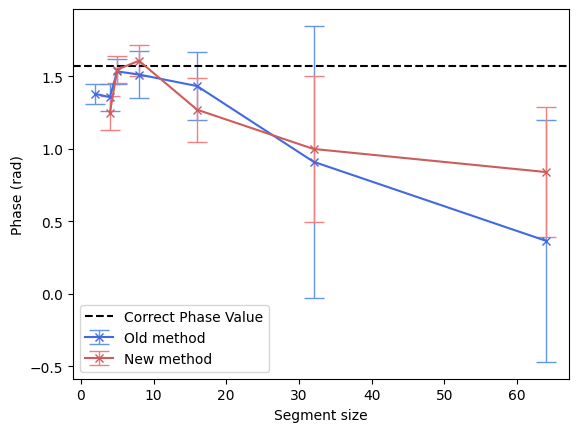

In [26]:
plt.errorbar(ss_list, method_1_phase, marker='x',  yerr=method_1_errs, c='royalblue', ecolor='cornflowerblue', capsize=7, elinewidth=1, label='Old method')
plt.errorbar(ss_list, method_2_phase, marker='x',  yerr=method_2_errs, c='indianred', ecolor='lightcoral', capsize=7, elinewidth=1, label='New method')
plt.axhline(1.5708, c='k', ls='--', label='Correct Phase Value')
plt.xlabel('Segment size')
plt.ylabel('Phase (rad)')
# plt.xlim(0,10)
plt.legend()
plt.savefig('C:/Users/shash/UvA/Thesis/Project/MastersThesis/data/processed/20250402_PhaseReconstructionComparison/Parameters_2/ComparisonResult.png')

# Manual Comparison

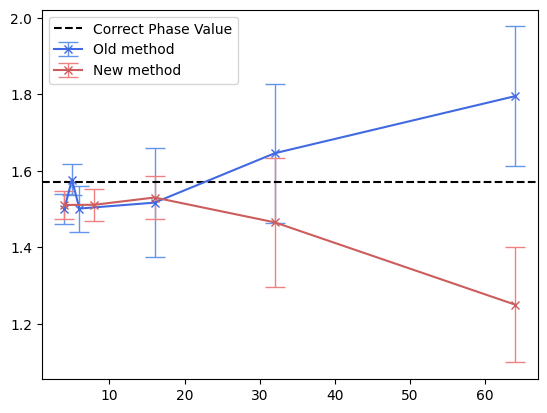

In [141]:
# Plots from manualy saved results

m1_phase_calcs = [1.5002, 1.577, 1.5013, 1.5168, 1.646, 1.7952]
m1_phase_errs = [0.038, 0.040, 0.060, 0.143, 0.182, 0.182]
m1_ss = [8 * 1/1/params_E1['nu_f'], 10 * 1/1/params_E1['nu_f'], 12 * 1/1/params_E1['nu_f'], 32 * 1/1/params_E1['nu_f'], 64 * 1/1/params_E1['nu_f'], 128 * 1/1/params_E1['nu_f']]

m2_phase_calcs = [1.5107, 1.5112, 1.5302, 1.4652, 1.2500]
m2_phase_errs = [0.037, 0.042, 0.057, 0.169, 0.151]
m2_ss = [4, 8, 16, 32, 64]

plt.errorbar(m1_ss, m1_phase_calcs, marker='x', yerr=m1_phase_errs, c='royalblue', ecolor='cornflowerblue', capsize=7, elinewidth=1, label='Old method')
plt.errorbar(m2_ss, m2_phase_calcs, marker='x',  yerr=m2_phase_errs, c='indianred', ecolor='lightcoral', capsize=7, elinewidth=1, label='New method')
plt.axhline(1.5708, c='k', ls='--', label='Correct Phase Value')
plt.legend()